In [229]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [337]:
uncertainty = pd.read_csv('../data/processed/uncertainty_index.csv')
ip = pd.read_csv('../data/processed/ip_index.csv', encoding='unicode_escape')

data = pd.merge(uncertainty,ip,on='period')

# Set 'period' as the index
data.set_index('period', inplace=True)

# Take the natural logarithm of both Y and X
# data['ln_EPU'] = np.log(data['IQ21320'])
# data['ln_STNSU'] = np.log(data['uncertainty'])
# Create a new column 'y_diff' representing the difference (lagged by 1 period) of 'y'
data['ip_diff'] = data['ip'].diff()
data.dropna(inplace=True)

data

,uncertainty,ip,ip_diff
period,,,
2000M08,0.144173,17.0097,0.2966
2000M09,0.365126,17.2867,0.2770
2000M10,0.266905,17.4958,0.2091
2000M11,0.124076,17.8917,0.3959
2000M12,0.065363,18.2370,0.3453
...,...,...,...
2023M05,0.675275,136.5650,1.1721
2023M06,0.536586,137.4773,0.9123
2023M07,0.225220,141.5320,4.0547


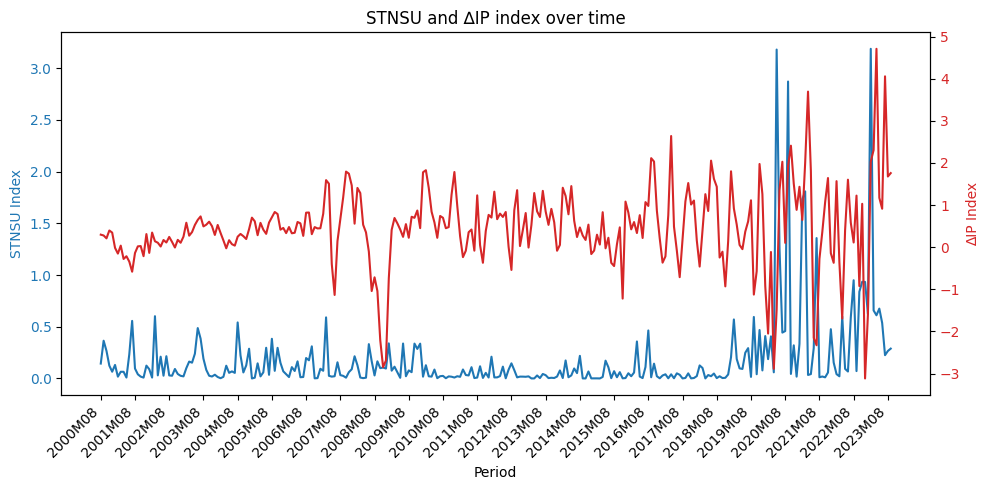

In [370]:

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the first time series on the left y-axis (ax1)
color = 'tab:blue'
ax1.set_xlabel('Period')
ax1.set_ylabel('STNSU Index', color=color)
ax1.plot(data.index, data['uncertainty'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis (ax2) on the right
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('∆IP Index', color=color)
ax2.plot(data.index, data['ip_diff'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set x-axis ticks at intervals of 12 periods and rotate x-labels
ax1.set_xticks(data.index[::12])
ax1.set_xticklabels(data.index[::12], rotation=45, ha='right')

# Show the plot
plt.title('STNSU and ∆IP index over time')
plt.tight_layout() 
plt.show()


### Model


In [351]:

Y = data['ip_diff']
X = data['uncertainty']


In [352]:
def lag_list(Y, X, p=1, q=0):
    '''
    待估计方程：y = c + y(-1) +....+y(-p) + x(-1) + ... + x(-q)
    获取自回归分布滞后模型的估计向量

    Parameters
    ----------
    Y : 被估计变量
    X : 估计变量
    p : ADL 模型 Y 的滞后阶数，标量默认为1
    q : ADL 模型 X 的滞后阶数，标量默认为1

    Returns
    -------
    ADLy : ADL 模型被解释变量
    ADLx : ADL 模型解释变量

    '''
    ADLx = pd.DataFrame()
    T = len(Y)
    ADLy = list(Y[max(p, q):T])
    for i in range(1, p+1):
        name = f'y_{i}'
        ADLx[name] = list(Y[max(p, q)-i:T-i])
    for i in range(1, q+1):
        name = f'x_{i}'
        ADLx[name] = list(X[max(p, q)-i:T-i])
        
    return ADLy, ADLx
    


In [366]:
import statsmodels.api as sm

# Define a function to fit the ADL model and calculate AIC
def fit_adl_model(Y, X, p, q):
    ADLy, ADLx = lag_list(Y, X, p, q)
    ADLx = sm.add_constant(ADLx)
    model = sm.OLS(ADLy, ADLx)
    results = model.fit()
    return results, results.aic

# Grid search for lag orders
best_aic = float('inf')
best_p, best_q = 0, 0

for p in range(1, 10 + 1):
    for q in range(0, 10 + 1):
        _, aic = fit_adl_model(Y, X, p, q)
        if aic < best_aic:
            best_aic = aic
            best_p, best_q = p, q

print("Best AIC:", best_aic)
print("Best p, q:", best_p, best_q)


Best AIC: 642.2742213313212
Best p, q: 4 10


In [371]:
# Model 1
ADLy1, ADLx1 = lag_list(Y, X, p=4, q=10)
ADLx1 = sm.add_constant(ADLx1)
mod1 = sm.OLS(ADLy1, ADLx1)
res1 = mod1.fit()

print("Summary for Model:")
print(res1.summary())

Summary for Model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     11.49
Date:                Sun, 14 Jan 2024   Prob (F-statistic):           2.28e-20
Time:                        13:40:05   Log-Likelihood:                -306.14
No. Observations:                 268   AIC:                             642.3
Df Residuals:                     253   BIC:                             696.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1805      0.068 

In [373]:
# Model 2
ADLy2, ADLx2 = lag_list(Y, X, p=4, q=0)
ADLx2 = sm.add_constant(ADLx2)
mod2 = sm.OLS(ADLy2, ADLx2)
res2 = mod2.fit()

print("Summary for Model:")
print(res2.summary())

Summary for Model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     23.37
Date:                Sun, 14 Jan 2024   Prob (F-statistic):           1.35e-16
Time:                        15:21:11   Log-Likelihood:                -337.52
No. Observations:                 274   AIC:                             685.0
Df Residuals:                     269   BIC:                             703.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2691      0.062 

In [387]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have test data and true values 'y_true'

# Get model predictions on the test data
y_pred_model1 = res1.predict(ADLx1)
y_pred_model2 = res2.predict(ADLx2)

# # Assuming 'period' is the name of the index in Y and y_pred_model1
# Set the index of y_pred_model1 to match the index of Y
y_pred_model1.index = Y.index[10:]  # Exclude the first element due to lag
error_model1 = Y[10:] - y_pred_model1  # Exclude the first element due to lag

y_pred_model2.index = Y.index[4:]
error_model2 = Y[4:] - y_pred_model2


# Calculate squared differences between forecast errors
squared_diff = (error_model1 - error_model2)**2

# Calculate mean squared differences
mean_squared_diff = np.mean(squared_diff)

# Calculate standard error of the mean squared differences
n = len(Y)
se_squared_diff = np.sqrt((1/n) * mean_squared_diff)

# Calculate DM statistic
dm_statistic = mean_squared_diff / se_squared_diff

# Print DM statistic
print("DM Statistic (Model 1 vs Model 2):", dm_statistic)


DM Statistic (Model 1 vs Model 2): 5.9022275689141415
